In [1]:
%%capture
%cd ../../

In [2]:
import sys

sys.path.extend(["recommender"])

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import os

from utils.encodes import gen_encode_cols
from utils.io import gen_dict, drop_cols, merge_dfs, drop_cols_list
from utils.metrics_report import get_multiclass_report

from omegaconf import DictConfig, OmegaConf

Matplotlib is building the font cache; this may take a moment.


In [4]:
current_dir = Path.cwd()
raw_data_dir = current_dir.joinpath("recommender/data/raw")
processed_data_dir = current_dir.joinpath("recommender/data/processed")
config_dir = current_dir.joinpath("recommender/configs")
artifacts_dir = current_dir.joinpath("recommender/models/artifacts")
features_dir = current_dir.joinpath("recommender/models/features")
filename = "kaggle_survey_2017_2021.csv"

In [5]:
## config calls
map_config = OmegaConf.load(config_dir.joinpath("col-mapping.yaml"))
colvals_config = OmegaConf.load(config_dir.joinpath("col-values.yaml"))

In [6]:
data = pd.read_csv(raw_data_dir.joinpath(filename), skiprows=1)
data = data[~data["What is your age (# years)?"].isna()]
data = data.fillna(0)
print(data.shape)

/home/ec2-user/SageMaker/.persisted_conda/authentifield/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245

(105856, 293)


In [7]:
data_dict = gen_dict(data)
data_dict

{0: 'Year',
 1: 'Duration (in seconds)',
 2: 'What is your age (# years)?',
 3: 'What is your gender? - Selected Choice',
 4: 'In which country do you currently reside?',
 5: 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
 6: 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
 7: 'For how many years have you been writing code and/or programming?',
 8: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python',
 9: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R',
 10: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL',
 11: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C',
 12: 'What programming languages do you use on a regular basis? (Select a

### Target prep

In [8]:
data["Target"] = data[data_dict.get(6)].copy()

data["Target"].value_counts()

/tmp/ipykernel_24073/1033024180.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Target'] = data[data_dict.get(6)].copy()


Student                                 21242
Data Scientist                          16910
Software Engineer                       10252
Data Analyst                             8489
Other                                    8346
0                                        6985
Research Scientist                       5371
Business Analyst                         4097
Currently not employed                   3638
Machine Learning Engineer                3192
Data Engineer                            2466
Product/Project Manager                  1843
Not employed                             1784
Software Developer/Software Engineer     1726
Statistician                             1451
Scientist/Researcher                      960
Program/Project Manager                   849
Consultant                                785
DBA/Database Engineer                     780
Researcher                                601
Research Assistant                        600
Manager                           

In [14]:
data = data[data["Target"] != "Currently not employed"]
data.loc[data["Target"] == 0, "Target"] = "Student"
data.loc[data["Target"] == 0, "Target"] = "Student"
se_list = ["Software Developer/Software Engineer", "Software Engineer"]
analyst = ["Business Analyst", "Data Analyst"]
research_eng = ["Researcher", "Scientist/Researcher"]
data.loc[data["Target"].isin(se_list), "Target"] = "Software Engineer"
data.loc[data["Target"].isin(research_eng), "Target"] = "Researcher"
data.loc[data["Target"].isin(analyst), "Target"] = "Data Analyst"
labels = [
    "Data Scientist",
    "Data Analyst",
    "Software Engineer",
    "Research Scientist",
    "Machine Learning Engineer",
    "Data Engineer",
    "Product/Project Manager",
    "Statistician",
]
data.loc[~data["Target"].isin(labels), "Target"] = "Other"

In [15]:
data["Year"] = data["Year"].astype(str)

In [16]:
data.head()

,Year,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,For how many years have you been writing code and/or programming?,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R,...,"In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Weights & Biases","In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Comet.ml","In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Sacred + Omniboard","In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - TensorBoard","In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Guild.ai","In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Polyaxon","In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Domino Model Monitor","In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - None","In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Other",Target
0,2021,910.0,50-54,Man,India,Bachelorâ€™s degree,Other,5-10 years,Python,R,...,0,0,0,0,0,0,0,0,0,Other
1,2021,784.0,50-54,Man,Indonesia,Masterâ€™s degree,Program/Project Manager,20+ years,0,0,...,0,0,0,0,0,0,0,None,0,Other
2,2021,924.0,22-24,Man,Pakistan,Masterâ€™s degree,Software Engineer,1-3 years,Python,0,...,0,0,0,TensorBoard,0,0,0,0,0,Software Engineer
3,2021,575.0,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,0,...,0,0,0,0,0,0,0,None,0,Research Scientist
4,2021,781.0,45-49,Man,India,Doctoral degree,Other,< 1 years,Python,0,...,0,0,0,0,0,0,0,0,0,Other


In [17]:
target_year = (
    data.groupby(["Year", "Target"])
    .size()
    .reset_index()
    .pivot(columns="Target", index="Year", values=0)
)
target_year = target_year.drop(columns=["Other"])

In [18]:
data[data_dict.get(4)].nunique()

78

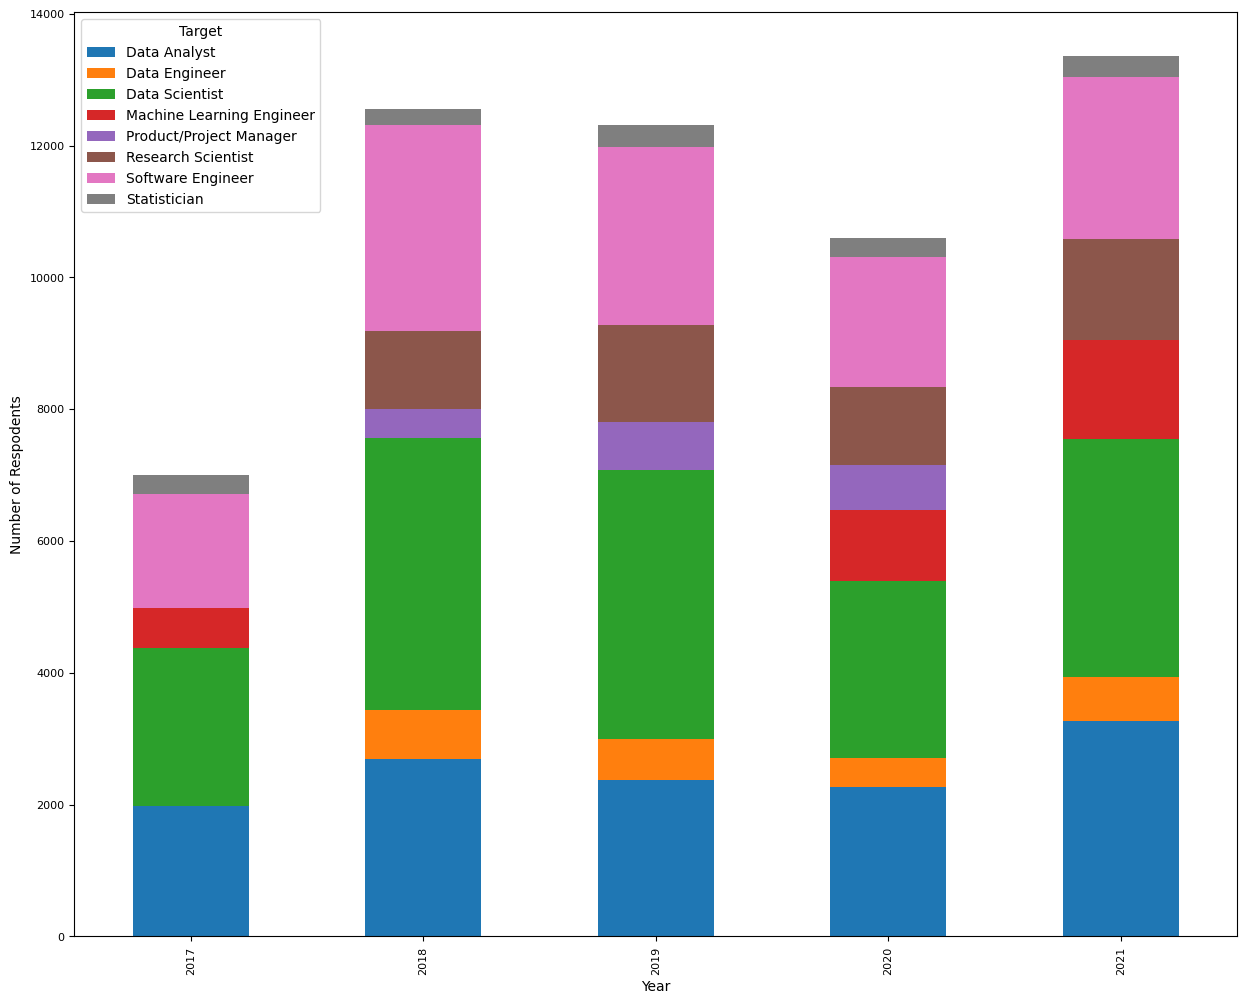

In [19]:
plt = target_year.plot(
    kind="bar",
    stacked=True,
    figsize=(15, 12),
    xlabel="Year",
    ylabel="Number of Respodents",
    fontsize=8,
)
plt.figure.savefig("Yearwise_Personas.jpg")

In [20]:
data["Country"] = data[data_dict.get(4)].copy()
target_country = (
    data.groupby(["Country", "Target"])
    .size()
    .reset_index()
    .pivot(columns="Target", index="Country", values=0)
)
target_country

Target,Data Analyst,Data Engineer,Data Scientist,Machine Learning Engineer,Other,Product/Project Manager,Research Scientist,Software Engineer,Statistician
Country,,,,,,,,,
0,1.0,NaN,1.0,1.0,16.0,NaN,NaN,1.0,NaN
Algeria,12.0,2.0,9.0,3.0,41.0,2.0,19.0,10.0,3.0
Argentina,99.0,12.0,136.0,16.0,234.0,15.0,40.0,77.0,4.0
Australia,246.0,30.0,264.0,19.0,679.0,28.0,63.0,117.0,22.0
Austria,14.0,4.0,33.0,1.0,49.0,4.0,24.0,27.0,6.0
...,...,...,...,...,...,...,...,...,...
United Kingdom of Great Britain and Northern Ireland,275.0,63.0,519.0,37.0,807.0,48.0,170.0,197.0,30.0
United States,473.0,NaN,759.0,124.0,2216.0,NaN,NaN,401.0,83.0
United States of America,1665.0,402.0,2558.0,203.0,4930.0,344.0,737.0,1315.0,171.0


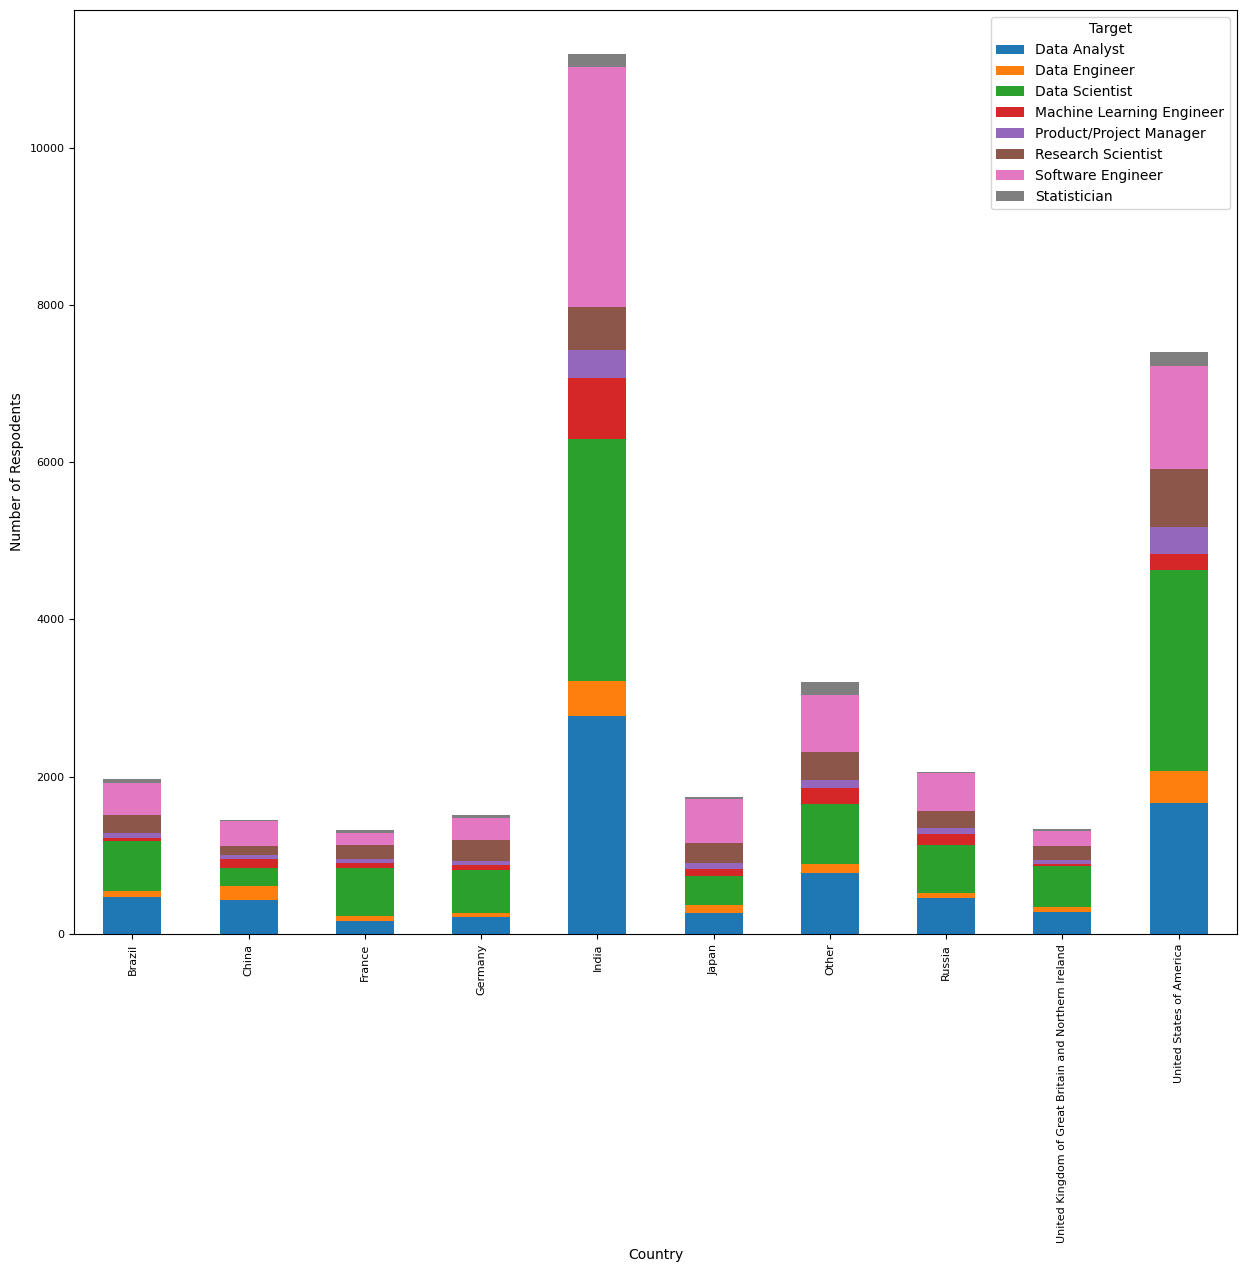

In [21]:
target_country = data.groupby(["Country"]).size().reset_index()
countries = list(target_country.sort_values(0, ascending=False)["Country"][0:11].values)
countries.remove("United States")

sub_country = data[data[data_dict.get(4)].isin(countries)]
target_country = (
    sub_country.groupby(["Country", "Target"])
    .size()
    .reset_index()
    .pivot(columns="Target", index="Country", values=0)
)
target_country = target_country.drop(columns=["Other"])
plt = target_country.plot(
    kind="bar",
    stacked=True,
    figsize=(15, 12),
    xlabel="Country",
    ylabel="Number of Respodents",
    fontsize=8,
)
plt.figure.savefig("Countrywise_Personas.jpg")

In [45]:
countries

array(['India', 'United States of America', 'Other', 'United States',
       'China', 'Brazil', 'Russia', 'Japan', 'Germany',
       'United Kingdom of Great Britain and Northern Ireland', 'France'],
      dtype=object)